In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt
from synthetic import generate_ds1
from kan import KAN

In [2]:
lag = 4  # number of lags
T = 1000  # number of time points
num_series = 2  # number of time series

lr = 1
mlp_epoch = 1000
max_iter = 1000
lamb = 0.001
reg_metric = 'node_backward'

dim_input = num_series * lag
dim_output = 1

layers = [dim_input, 8, 4, dim_output]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

$$Z_t = \tanh(Z_{t-1}) + N(0, 0.01^2)$$
$$U_t = Z_t^2 + N(0, 0.05^2)$$
$$X_t = \sin(X_{t-1}) + N(0, 0.01^2)$$

No Granger:
$$Y_t = \sigma(Z_{t-4}) + N(0, 0.01^2)$$

Granger:
$$Y_t = \sigma(Z_{t-4}) + \sigma(X_{t-4}) + N(0, 0.01^2)$$

In [3]:
X_np = generate_ds1(T)
X_np

,z,u,x,y_ngc,y_gc
0,0.768904,0.611221,0.150907,1.000689,1.885220
1,0.651790,0.417262,0.149303,0.732499,1.717178
2,0.577964,0.340126,0.153188,0.895738,1.615192
3,0.523461,0.231306,0.127059,0.739703,1.690169
4,0.497635,0.174923,0.127175,0.698611,1.219067
...,...,...,...,...,...
995,-0.087389,-0.086045,0.134557,0.469360,1.007596
996,-0.084847,-0.049761,0.134048,0.457808,0.998351
997,-0.102935,-0.119351,0.135629,0.474353,1.004759
998,-0.089104,0.042743,0.142035,0.485441,1.005743


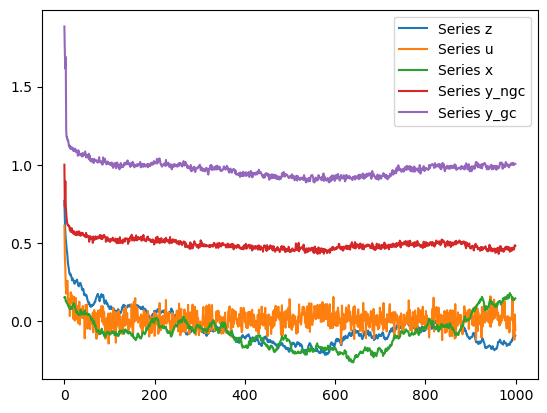

In [4]:
# Plot data
for i in range(len(X_np.columns)):
    plt.plot(X_np.index, X_np.iloc[:, i], label='Series {}'.format(X_np.columns[i]))
plt.legend()
plt.show()

In [5]:
# transfer dataframe to tensor 
# drop z
X_np = X_np.drop(columns=['z'])
X_np = torch.tensor(X_np.values, dtype=torch.float32).to(device)

# add one new dimension to the tensor
X = X_np.unsqueeze(0)

train = X[:, :, :-2]
y_no_GC = X[:, :, -2]
y_GC = X[:, :, -1]

# rearrrange the data
def rearrange_data(train, y, lag):
    li = []
    for i in range(train.shape[2]):
        for j in range(lag):
            li.append(train[0, :, i].detach().numpy()[j:-lag+j])
    train = torch.tensor(np.array(li).T, dtype=torch.float32).to(device)

    y = y[:, lag:].T
    array = torch.cat((train, y), 1)
    
    return array

# put data into a dictionary
def create_dataset(X):
    dataset = {}
    dataset['train_input'] = X[:, :-1]
    dataset['test_input'] = X[:, :-1]
    dataset['train_label'] = X[:, -1]
    dataset['test_label'] = X[:, -1]

    return dataset

def get_ts_scores(model):
    ts_scores = model.node_scores[0].view(num_series, lag).sum(dim=1).detach().numpy()
    ts_scores = ts_scores / ts_scores.sum()
    return ts_scores
    
array_no_GC = rearrange_data(train, y_no_GC, lag)
array_GC = rearrange_data(train, y_GC, lag)
print(array_no_GC.shape)

ds_GC = create_dataset(array_GC)
ds_no_GC = create_dataset(array_no_GC)

torch.Size([996, 9])


## Build KAN for Dataset

In [6]:
# Model 1: KAN with GC
kan_model1 = KAN(width=layers, grid=3, k=3, seed=42)
kan_loss1 = kan_model1.fit(ds_GC, opt='Adam', lr=lr, steps=max_iter, lamb=lamb, reg_metric=reg_metric)['train_loss']

# Model 2: KAN without GC
kan_model2 = KAN(width=layers, grid=3, k=3, seed=42)
kan_loss2 = kan_model2.fit(ds_no_GC, opt='Adam', lr=lr, steps=max_iter, lamb=lamb, reg_metric=reg_metric)['train_loss']


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.62e-02 | test_loss: 1.04e-01 | reg: 9.21e+01 | : 100%|█| 1000/1000 [00:57<00:00, 17.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.64e-02 | test_loss: 3.65e-02 | reg: 2.74e+01 | : 100%|█| 1000/1000 [00:55<00:00, 17.


saving model version 0.1


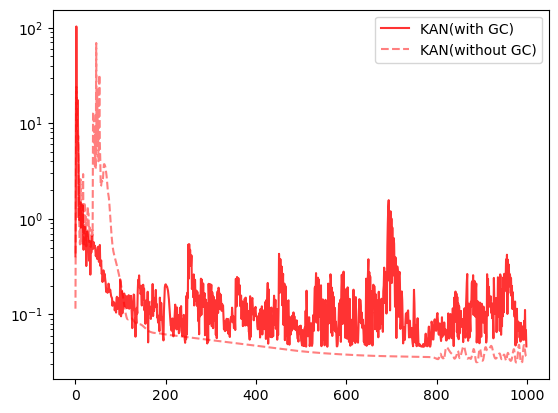

GC score for Model1  u:0.09833301603794098 | x:0.9016669988632202
GC score for Model2  u:0.31965041160583496 | x:0.6803495287895203


In [7]:
# plot loss
plt.plot(kan_loss1, label='KAN(with GC)', color='red', alpha=0.8)
plt.plot(kan_loss2, label='KAN(without GC)', color='red', alpha=0.5, linestyle='dashed')
plt.yscale('log')
plt.legend()
plt.show()

print('GC score for Model1  u:{} | x:{}'.format(get_ts_scores(kan_model1)[0], get_ts_scores(kan_model1)[1]))
print('GC score for Model2  u:{} | x:{}'.format(get_ts_scores(kan_model2)[0], get_ts_scores(kan_model2)[1]))

## Build MLP for GC

In [8]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.layers.append(nn.ReLU())
        # initialize weights
        # self.init_weights()

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
def loss_fn(y_pred, y_true, model, lamb):
    loss = nn.MSELoss()(y_pred, y_true)
    # L2 regularization for the first layer
    l2_reg = 0
    for param in model.layers[0].parameters():
        l2_reg += torch.norm(param, p=2)
    return loss + lamb * l2_reg

# print the weights of the first layer
def get_mlp_scores(model):
    scores = torch.norm(model.layers[0].weight, dim=0).view(num_series, lag).sum(dim=1).detach().numpy()
    scores = scores / scores.sum()
    return scores

In [9]:
layers = [dim_input, 8, 4, dim_output]

def train_mlp(withGC=True):
    if withGC:
        ds = ds_GC
    else:
        ds = ds_no_GC

    mlp_model = MLP(layers).to(device)
    optimizer = optim.Adam(mlp_model.parameters(), lr=lr)

    mlp_loss = []
    for i in range(mlp_epoch):
        optimizer.zero_grad()
        y_pred = mlp_model(ds['train_input'])
        loss = loss_fn(y_pred, ds['train_label'], mlp_model, lamb)
        loss.backward()
        optimizer.step()
        mlp_loss.append(loss.item())

        if (i+1) % 50 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(i+1, mlp_epoch, loss.item()))

    return mlp_model, mlp_loss

mlp_GC, mlp_loss1 = train_mlp(withGC=True)
mlp_no_GC, mlp_loss2 = train_mlp(withGC=False)

/Users/mohanren/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([996])) that is different to the input size (torch.Size([996, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [50/1000], Loss: 0.0692
Epoch [100/1000], Loss: 0.0539
Epoch [150/1000], Loss: 0.0515
Epoch [200/1000], Loss: 0.0497
Epoch [250/1000], Loss: 0.0480
Epoch [300/1000], Loss: 0.0465
Epoch [350/1000], Loss: 0.0451
Epoch [400/1000], Loss: 0.0438
Epoch [450/1000], Loss: 0.0426
Epoch [500/1000], Loss: 0.0414
Epoch [550/1000], Loss: 0.0403
Epoch [600/1000], Loss: 0.0392
Epoch [650/1000], Loss: 0.0381
Epoch [700/1000], Loss: 0.0371
Epoch [750/1000], Loss: 0.0360
Epoch [800/1000], Loss: 0.0350
Epoch [850/1000], Loss: 0.0340
Epoch [900/1000], Loss: 0.0331
Epoch [950/1000], Loss: 0.0321
Epoch [1000/1000], Loss: 0.0312
Epoch [50/1000], Loss: 0.0535
Epoch [100/1000], Loss: 0.0521
Epoch [150/1000], Loss: 0.0503
Epoch [200/1000], Loss: 0.0484
Epoch [250/1000], Loss: 0.0467
Epoch [300/1000], Loss: 0.0451
Epoch [350/1000], Loss: 0.0437
Epoch [400/1000], Loss: 0.0424
Epoch [450/1000], Loss: 0.0412
Epoch [500/1000], Loss: 0.0401
Epoch [550/1000], Loss: 0.0390
Epoch [600/1000], Loss: 0.0380
Epoch [65

In [10]:
print('GC score for MLP model1:', get_mlp_scores(mlp_GC))
print('GC score for MLP model2:', get_mlp_scores(mlp_no_GC))

GC score for MLP model1: [0.31689054 0.6831094 ]
GC score for MLP model2: [0.29333293 0.706667  ]


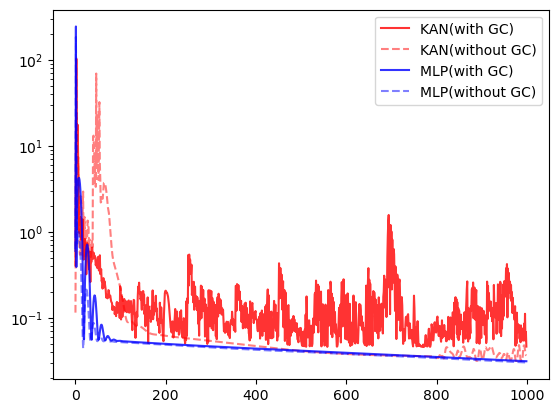

In [11]:
# plot the loss of KAN and MLP
plt.plot(kan_loss1, label='KAN(with GC)', color='red', alpha=0.8)
plt.plot(kan_loss2, label='KAN(without GC)', color='red', alpha=0.5, linestyle='dashed')
plt.plot(mlp_loss1, label='MLP(with GC)', color='blue', alpha=0.8)
plt.plot(mlp_loss2, label='MLP(without GC)', color='blue', alpha=0.5, linestyle='dashed')
plt.yscale('log')
plt.legend()
plt.show()